In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load the cleaned data
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')

# Step 1: Drop swimmers with records in multiple divisions (transfers)
division_counts = df.groupby('ID')['Division'].nunique()
transfer_swimmers = division_counts[division_counts > 2].index
df = df[~df['ID'].isin(transfer_swimmers)]

# Step 2: Categorize stroke types
def categorize_stroke(event):
    if 'Freestyle' in event:
        return 'Freestyle'
    elif 'Backstroke' in event:
        return 'Backstroke'
    elif 'Breaststroke' in event:
        return 'Breaststroke'
    elif 'Butterfly' in event:
        return 'Butterfly'
    elif 'Medley' in event:
        return 'Medley'
    else:
        return 'Other'

df['Stroke'] = df['Event'].astype('string').apply(categorize_stroke)

# Step 3: Compute improvement between high school and college
def weighted_top_4_avg(points):
    weight_factors = [0.2, 0.2, 0.2, 0.2, 0.2]
    top_5 = np.sort(points)[-5:][::-1]  # Get 5 highest values
    if len(top_5) < 5:
        top_5 = np.pad(top_5, (0, 5 - len(top_5)), 'constant', constant_values=(0,))
    return np.dot(top_5, weight_factors)

hs_df = df[df['Division'] == 'HS']
college_df = df[df['Division'] != 'HS']

hs_points = hs_df.groupby('ID', group_keys=False).apply(lambda group: weighted_top_4_avg(group['Points'].values))
college_points = college_df.groupby('ID', group_keys=False).apply(lambda group: weighted_top_4_avg(group['Points'].values))

df['Improvement'] = df['ID'].map(college_points - hs_points)

/tmp/ipykernel_511230/855984488.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hs_points = hs_df.groupby('ID', group_keys=False).apply(lambda group: weighted_top_4_avg(group['Points'].values))
/tmp/ipykernel_511230/855984488.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  college_points = college_df.groupby('ID', group_keys=False).apply(lambda group: weighted_top_4_avg(group['Points'].values))


In [2]:
df = df[(df['Improvement'] != float('-inf')) & 
   (df['Improvement'] != float('inf')) & 
   (df['Improvement'].notna())]


/tmp/ipykernel_511230/2012742132.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_specialty = stroke_total_points.groupby('ID', group_keys=False).apply(assign_specialty).reset_index(name='Specialty')


Best parameters found:  {'model__C': np.float64(0.06951927961775606)}
Best cross-validation score:  0.6072451775982136
Accuracy: 0.6113330911732655
Best C based on validation accuracy: 0.06951927961775606, Validation Accuracy: 0.6072451775982136
             C  train accuracy  validation accuracy
0     0.000100        0.527244             0.525425
1     0.000207        0.573148             0.570015
2     0.000428        0.605272             0.601253
3     0.000886        0.608314             0.606337
4     0.001833        0.605862             0.604521
5     0.003793        0.607201             0.605611
6     0.007848        0.606520             0.605157
7     0.016238        0.609880             0.606337
8     0.033598        0.610470             0.606973
9     0.069519        0.610629             0.607245
10    0.143845        0.610152             0.606065
11    0.297635        0.610538             0.606428
12    0.615848        0.610538             0.606428
13    1.274275        0.61

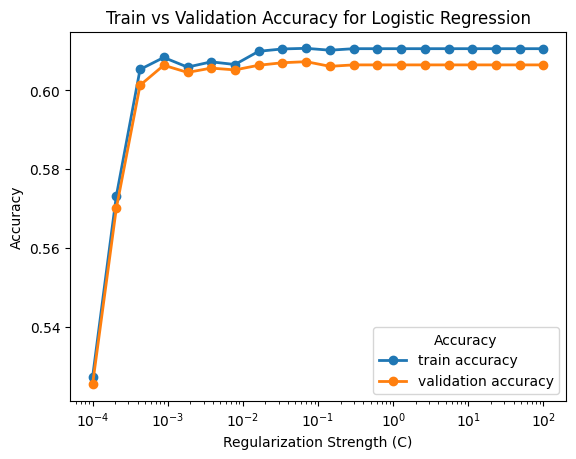

In [3]:
# Handle qcut error when all values are the same or too few unique values
if df['Improvement'].nunique() > 1:
    df['ImprovementBin'] = pd.qcut(df['Improvement'], q=2, labels=False, duplicates='drop')
    df['ImprovementBinLabel'] = df['ImprovementBin'].map({0: "Bad", 1: "Good"})
else:
    df['ImprovementBin'] = 0
    df['ImprovementBinLabel'] = "Same"

# Step 4: For each swimmer, find the stroke with the highest total points
def assign_specialty(swimmer_df):
    return swimmer_df.iloc[0]['Stroke']

stroke_total_points = df.loc[df.groupby('ID')['Points'].idxmax(), ['ID', 'Stroke', 'Points']].reset_index(drop=True)
df_specialty = stroke_total_points.groupby('ID', group_keys=False).apply(assign_specialty).reset_index(name='Specialty')


# Step 5: Merge the specialty info back into the main dataset
df = df.merge(df_specialty, on='ID')

# Step 6: Create 'power_tot_rating' based on 'Power_Tot'
df['power_tot_rating'] = pd.qcut(df['Power_Tot'], q=5, labels=[5, 4, 3, 2, 1])

# Step 7: Prepare df_summary
df_summary = df.groupby('ID').agg({
    'power_tot_rating': 'first',
    'ImprovementBin': 'first',
    'Division': 'last',
    'Gender': 'first',
    'School': 'first',
    'Specialty': 'first'
}).reset_index()

# Step 8: Apply OneHotEncoder to categorical columns
categorical_columns = ['Division', 'Gender', 'Specialty']
encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_categorical_features = encoder.fit_transform(df_summary[categorical_columns])
encoded_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(categorical_columns))
encoded_df['power_tot_rating'] = df_summary['power_tot_rating']

# Step 9: Logistic Regression with finer GridSearchCV
X = encoded_df
y = df_summary['ImprovementBin']

pipeline = Pipeline(steps=[('model', LogisticRegression(max_iter=1000))])

# Finer tuning of C values
parameters = {'model__C': np.logspace(-4, 2, 20)}  # More granularity in range

log_reg_cv = GridSearchCV(pipeline, param_grid=parameters, return_train_score=True, n_jobs=-1)
log_reg_cv.fit(X, y)

print("Best parameters found: ", log_reg_cv.best_params_)
print("Best cross-validation score: ", log_reg_cv.best_score_)

# Step 10: Post-analysis
accuracy = log_reg_cv.score(X, y)
print('Accuracy:', accuracy)

# Extracting results
c_values = log_reg_cv.cv_results_['param_model__C']
train_acc = log_reg_cv.cv_results_['mean_train_score']
val_acc = log_reg_cv.cv_results_['mean_test_score']

results = pd.DataFrame({
    'C': c_values,
    'train accuracy': train_acc,
    'validation accuracy': val_acc
})

# Print C value with the highest validation accuracy
best_c_index = np.argmax(val_acc)
best_c_value = c_values[best_c_index]
best_val_acc = val_acc[best_c_index]

print(f"Best C based on validation accuracy: {best_c_value}, Validation Accuracy: {best_val_acc}")

print(results)

# Step 11: Plot accuracy
results.plot(x='C', y=['train accuracy', 'validation accuracy'], marker='o', linestyle='-', linewidth=2)
plt.xscale('log')
plt.title('Train vs Validation Accuracy for Logistic Regression')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.legend(title='Accuracy')
plt.show()


In [4]:
df.ImprovementBinLabel.value_counts(normalize=True)

ImprovementBinLabel
Bad     0.500048
Good    0.499952
Name: proportion, dtype: float64

Cross-validation accuracy scores: [0.62051748 0.61007717 0.61080836 0.59900091 0.59582198]
Mean CV accuracy: 0.6072451775982136
Feature Importances (Signed Coefficients):


Specialty_Breaststroke    0.464287
Gender_M                  0.457656
Division_II               0.076002
Division_I                0.055661
Specialty_Backstroke      0.050174
Specialty_Butterfly      -0.045468
Division_III             -0.131493
power_tot_rating         -0.133712
Specialty_Freestyle      -0.180315
Specialty_Medley         -0.288507
Gender_F                 -0.457485
dtype: float64

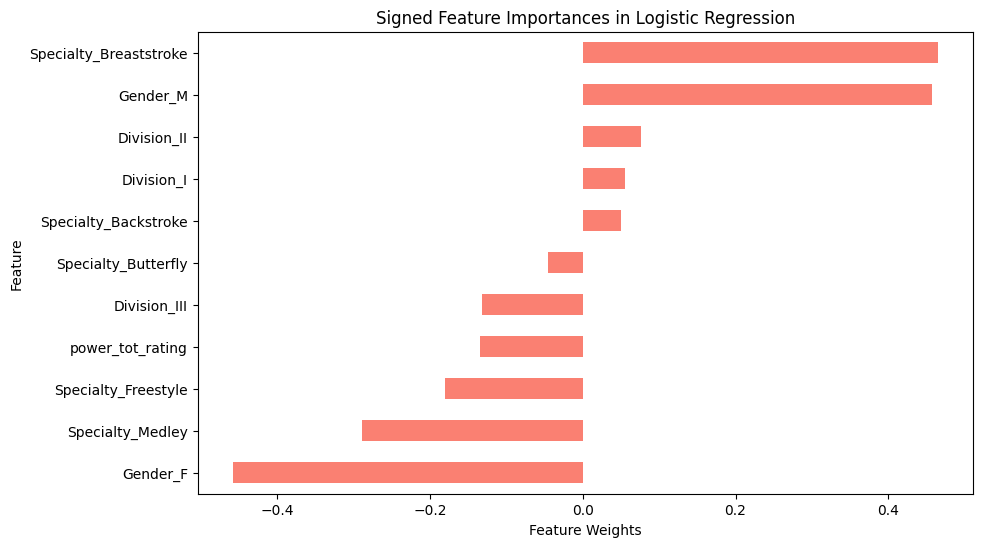

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Train Logistic Regression with C = 0.1
log_reg = LogisticRegression(C=0.06951927961775606, max_iter=1000, penalty = 'l2', solver = 'saga')
# log_reg = LogisticRegression(C=0.01623776739188721, max_iter=1000)

log_reg.fit(X, y)

# Perform cross-validation
cv_scores = cross_val_score(log_reg, X, y, cv=5)
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores)}")

# Get signed feature importances (coefficients)
coef = pd.Series(log_reg.coef_[0], index=X.columns)

# Display sorted coefficients
print("Feature Importances (Signed Coefficients):")
display(coef.sort_values(ascending=False))

# Plot feature importances with signs
plt.figure(figsize=(10, 6))
coef.sort_values().plot.barh(color='salmon')
plt.xlabel('Feature Weights')
plt.ylabel('Feature')
plt.title('Signed Feature Importances in Logistic Regression')
plt.show()


In [6]:
df_summary[df_summary.ID==1218609]

,ID,power_tot_rating,ImprovementBin,Division,Gender,School,Specialty
9970,1218609,4,1,III,M,Franklin College,Butterfly
